In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir

%matplotlib inline
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

from os import listdir

from tqdm.notebook import tqdm

# Load data

In [3]:
DATA_DIR = join("private", "prior_experiment_data")

## Behavioural data

In [4]:
def read_behavioural_data(data_dir, conditions=["HighCarb", "HighPro"]):
    """This function reads, processes and combines all .mat files
    containing behavioural data from the prior experiment run in Soyoung's Lab
    and transforms them into a single pandas.DataFrame.
    
    Args:
        data_dir (str): Path to the data directory with folders for data from each condition.
        conditions (list): List of condition names. These must match the name of the folders in `data_dir`
    
    Returns:
        pandas.DataFrame: Formatted data.
    """

    columns = [
        "trial",  # 1-100
        "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
        "trial_s",  # trial count in reversal block 1 to min 10 and max 16
        "correct_response",  # 1 left side correct, 0 right side correct
        "_",  # response recorded: 1 button was pressed, 0 no button was pressed
        "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
        "r",  # feedback: 1 smiley, 0 frowny
        "correct",  # resposne correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
        "_",  # timestamp "scan0"
        "_",  # timestamp "exp0"
        "_",  # timestamp "stimulus onset"
        "rt",  # response time
        "_",  # timestamp "feedback onset"
        "_",  # timestamp "fixation onset"
        "_",  # intertrial interval
    ]

    df = []

    for condition in conditions:
        # List all mat files
        matfiles = [
            file for file in listdir(join(data_dir, condition)) if file.endswith(".mat")
        ]

        for filename in matfiles:
            # Extract subject ID
            # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
            subject = int(filename[20:22])
            session = int(filename[30:32])
            block = int(filename[33:34]) - 1

            # Load data of single subject and condition
            x = loadmat(join(data_dir, condition, filename))
            df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
            df_sc["condition"] = condition.lower()
            df_sc["subject"] = subject
            df_sc["session"] = session
            df_sc["block"] = block

            # Append to list of all dataframes
            df.append(df_sc)

    # Concatenate all dataframes
    df = pd.concat(df)

    # Reformat variables
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["a"] = (df["a"] - 98).astype(
        np.int32
    )  # Recode from 98 = left 99 = right to 0 = left, 1 = right
    df.loc[df["a"] == -98, "a"] = np.nan
    df["s"] = 0
    df["state"] = df["state"].astype(np.int32)

    return df
    return (
        df[
            [
                "subject",
                "block",
                "trial",
                "state",
                "s",
                "a",
                "r",
                "session",
                "condition",
            ]
        ]
        .sort_values(["condition", "subject", "block", "trial"])
        .reset_index(drop=True)
    )

In [5]:
bh = read_behavioural_data(join(DATA_DIR, "Behav"), conditions=["HighCarb", "HighPro"])
bh.head()

,trial,state,trial_s,correct_response,_,a,r,correct,_,_,_,rt,_,_,_,condition,subject,session,block,s
0,0,1,1.0,0.0,1.0,0.0,0.0,1.0,13908.776335,13908.776468,0.009624,0.522540,0.543223,1.559783,2.0,highcarb,5,2,1,0
1,1,1,2.0,1.0,1.0,1.0,0.0,0.0,13908.776335,13908.776468,3.593000,0.432014,4.043072,5.059572,2.0,highcarb,5,2,1,0
2,2,1,3.0,0.0,1.0,0.0,0.0,1.0,13908.776335,13908.776468,7.092740,0.397094,7.509472,8.526039,8.0,highcarb,5,2,1,0
3,3,1,4.0,1.0,1.0,1.0,0.0,0.0,13908.776335,13908.776468,16.558749,0.411769,16.992201,18.008788,2.0,highcarb,5,2,1,0
4,4,1,5.0,1.0,1.0,0.0,1.0,1.0,13908.776335,13908.776468,20.041900,0.441531,20.491976,21.508536,6.0,highcarb,5,2,1,0


In [6]:
len(bh)

7800

This should be 8000 (20 subjects * 2 conditions * 2 blocks * 100 trials).

In [7]:
bh["subject"].value_counts().sort_values()[:5]

13    200
11    400
7     400
3     400
18    400
Name: subject, dtype: int64

In [8]:
bh.loc[bh["subject"] == 13, "condition"].unique()

array(['highpro'], dtype=object)

Subject 13 is missing in `HighCarb` condition.

### Visualize some data

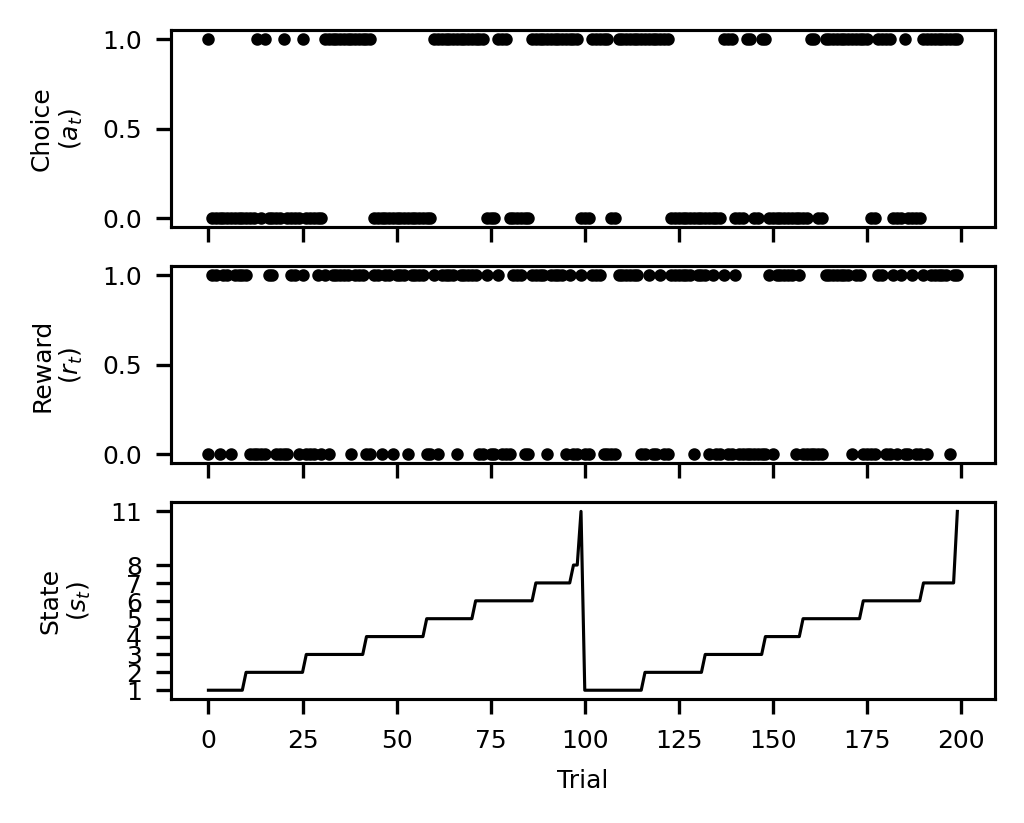

In [9]:
data = (bh.loc[(bh["subject"] == 1) & (bh["condition"] == "highcarb")]).reset_index(
    drop=True
)
rl.plots.plot_data(data);

Looks like the state variable (Column 2 in the original data set) is something else. Maybe an count of the number of reversals? Still, numbers 9 and 10 are missing from it. Not sure. This is not important for fitting, if the other variables are coded correctly, though, because the agent only assumes one state anyway in the task.

In [10]:
bh["a"].isnull().groupby(bh["subject"]).sum()

subject
1      1
2     13
3      0
4     93
5      0
6      0
7      6
8      1
9      1
10     1
11     1
12     0
13     3
14    13
15     6
16     1
17    17
18     3
19     0
20     3
Name: a, dtype: int64

There are some subjects with a considerable number of trials without response (e.g., subject 4 misses 93 trials in total!).

## Physiological data

In [11]:
def read_physiological_data(phys_data_file):
    """This function reads and processes the
    physiological data from wide Excel .xlsx
    to a long pandas.DataFrame
    
    Args:
        phys_data_file (str): Path to the Excel file containing physiological data.
        
    Returns:
        pandas.DataFrame: Long pandas.DataFrame
    """

    ph = pd.read_excel(phys_data_file)

    ph.rename(
        {
            "Sub_ID": "subject",
            "AUC_Tyr_HighCarb": "tyr-highcarb",
            "AUC_Tyr_HighPro": "tyr-highpro",
            "AUC_Trp_HighCarb": "trp-highcarb",
            "AUC_Trp_HighPro": "trp-highpro",
        },
        axis=1,
        inplace=True,
    )
    ph["subject"] = ph["subject"].apply(lambda x: int(x[1:]))

    ph = (
        pd.wide_to_long(
            ph,
            stubnames=["tyr", "trp"],
            i="subject",
            j="condition",
            sep="-",
            suffix="\\w+",
        )
        .sort_values(["subject", "condition"])
        .reset_index()
    )
    return ph

In [12]:
ph = read_physiological_data(join(DATA_DIR, "Blood.xlsx"))
ph.head()

,subject,condition,tyr,trp
0,1,highcarb,0.518,0.688
1,1,highpro,0.487,0.529
2,2,highcarb,0.635,0.838
3,2,highpro,0.593,0.658
4,3,highcarb,0.587,0.823


# Visualize data

In [13]:
import seaborn as sns
from scipy.stats import sem

In [14]:
ph_desc = ph.groupby("condition")[["tyr", "trp"]].agg([np.mean, sem])
ph_desc

tyr               trp          
              mean       sem    mean       sem
condition                                     
highcarb   0.59635  0.017623  0.6984  0.021702
highpro    0.63985  0.020172  0.5806  0.020744

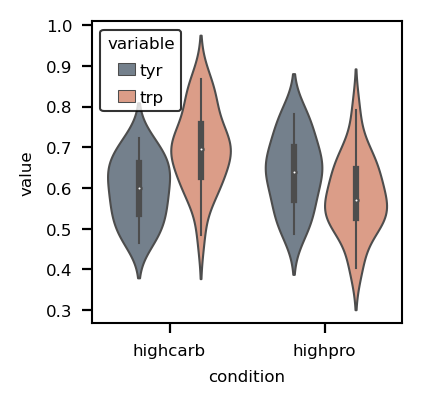

In [15]:
ph_longer = ph.melt(id_vars=["subject", "condition"], value_vars=["tyr", "trp"])
fig, ax = plt.subplots(figsize=(2, 2), dpi=200)
ax = sns.violinplot(
    x="condition", y="value", hue="variable", data=ph_longer, kind="violin", ax=ax
)

Check out differences between conditions

In [16]:
ph_wide = ph.pivot(index="subject", columns="condition")

In [17]:
for var in ["tyr", "trp"]:
    diff = ph_wide[var]["highcarb"] - ph_wide[var]["highpro"]
    ph_wide[(var, "diff")] = diff
ph_wide

tyr              trp            tyr    trp
condition highcarb highpro highcarb highpro   diff   diff
subject                                                  
1            0.518   0.487    0.688   0.529  0.031  0.159
2            0.635   0.593    0.838   0.658  0.042  0.180
3            0.587   0.619    0.823   0.791 -0.032  0.032
4            0.572   0.632    0.603   0.531 -0.060  0.072
5            0.519   0.509    0.696   0.516  0.010  0.180
6            0.466   0.513    0.596   0.519 -0.047  0.077
7            0.611   0.577    0.682   0.608  0.034  0.074
8            0.682   0.668    0.703   0.592  0.014  0.111
9            0.632   0.683    0.822   0.586 -0.051  0.236
10           0.667   0.641    0.613   0.403  0.026  0.210
11           0.542   0.732    0.697   0.669 -0.190  0.028
12           0.493   0.782    0.632   0.707 -0.289 -0.075
13           0.625   0.695    0.768   0.547 -0.070  0.221
14           0.723   0.718    0.586   0.644  0.005 -0.058
15           0.716   0.765    0.717   0.536 -0.049  0.181
16           0.678   0.778    0.869   0.669 -0.100  0.200
17           0.549   0.554    0.677   0.507 -0.005  0.170
18           0.659   0.639    0.719   0.557  0.020  0.162
19           0.474   0.549    0.484   0.432 -0.075  0.052
20           0.579   0.663    0.755   0.611 -0.084  0.144

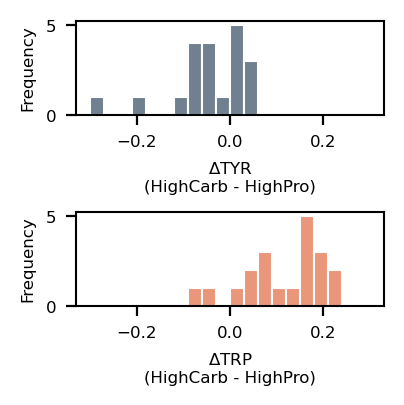

In [18]:
bins = np.linspace(-0.3, 0.3, 21)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2, 2), dpi=200)
for i, var in enumerate(["tyr", "trp"]):
    axs[i].hist(ph_wide[(var, "diff")], bins=bins, color=f"C{i}", edgecolor="white")
    axs[i].set_xlabel("$\Delta$" + var.upper() + "\n(HighCarb - HighPro)")
    axs[i].set_ylabel("Frequency")
    axs[i].xaxis.set_tick_params(which="both", labelbottom=True)
fig.tight_layout()

# Fit reinforcement learning model

In [19]:
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2, n_states=1)

In [20]:
# Initialize estimation variables

# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 100)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

## Fit `HighCarb` and `HighPro` conditions separately

In [ ]:
# Initialize agent_vars
agent_vars = rl.agent.AgentVars(variant="r")

results = {}

# Cycle over conditions
conditions = ["highcarb", "highpro"]
for condition in conditions:
    print(f"Estimating parameters for '{condition}' condition.")

    results[condition] = []

    # Cycle over subjects with data in that condition
    for subject in tqdm(bh.loc[bh["condition"] == condition, "subject"].unique()):
        print(f"  Subject {subject}")

        # Subject DataFrame
        df_s = bh.loc[(bh["subject"] == subject) & (bh["condition"] == condition)]

        # Now we can estimate the maximum likelihood parameters
        result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

        # Save results to DataFrame
        result_df = pd.DataFrame(
            dict(
                subject=subject,
                nll=result[0],
                bic=result[1],
                alpha_pos=result[2][0],
                alpha_neg=result[2][1],
                beta=result[2][2],
            ),
            index=[subject],
        )
        results[condition].append(result_df)

    # Concatenate results for this condition, across subjects
    results[condition] = (
        pd.concat(results[condition]).sort_values("subject").reset_index(drop=True)
    )
    results[condition]["condition"] = condition

# Concatenate results across conditions
results = pd.concat([results[condition] for condition in conditions]).reset_index(
    drop=True
)
results.to_csv("parklab_RWpn-estimates.csv")

Estimating parameters for 'highcarb' condition.


  Subject 5
  Subject 3
  Subject 7
  Subject 11
  Subject 20
  Subject 10
  Subject 2
  Subject 9
  Subject 8
  Subject 4
  Subject 1
  Subject 18
  Subject 19
  Subject 15
  Subject 16
  Subject 6
  Subject 12
  Subject 14
  Subject 17

Estimating parameters for 'highpro' condition.


  Subject 7
  Subject 17
  Subject 19
  Subject 4


# Perform analyses on parameter estimates and physiological measures

In [ ]:
# join DataFrames
df = (
    results.merge(ph, on=["subject", "condition"], how="outer")
    .sort_values(["subject", "condition"])
    .reset_index(drop=True)[
        [
            "subject",
            "condition",
            "tyr",
            "trp",
            "nll",
            "bic",
            "alpha_pos",
            "alpha_neg",
            "beta",
        ]
    ]
)
df.head()

## Correlation of parameters and physiological measures across conditions

In [ ]:
from scipy.stats import linregress

In [ ]:
def pairplot(df):
    vars = df.columns
    nVars = len(vars)
    fig, axs = plt.subplots(
        nVars, nVars, figsize=(nVars, nVars), dpi=200, sharex="col",
    )

    for i, var_y in enumerate(vars):
        for j, var_x in enumerate(vars):
            ax = axs[i, j]
            # Switch off upper right triangle
            if j > i:
                ax.axis("off")

            # Make a histogram on diagonal
            elif var_x == var_y:
                ax.hist(df[var_x], edgecolor="white")
                ax.set_ylabel("Frequency")

            # Otherwise make a regression plot
            else:
                x = df[var_x].values
                y = df[var_y].values
                xs = np.linspace(x.min(), x.max(), 100)
                b, a, r, p, _ = linregress(x=x, y=y)
                print(
                    f"LinReg: {var_y} ~ {var_x}\n  b={b:.2f}, a={a:.2f}, r={r:.2f}, p={p:.2f}"
                )
                ax.plot(x, y, "o", markeredgewidth=0.3)
                ax.plot(xs, a + b * xs, color="black")
                ax.set_xlabel(var_x)
                ax.set_ylabel(var_y)

            ax.xaxis.set_tick_params(which="both", labelbottom=True)
            ax.yaxis.set_tick_params(which="both", labelbottom=True)

    fig.tight_layout()

    return fig, axs

In [ ]:
pairplot(df[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna());

## Correlation of learning rates and physiological measures, within each condition

## Correlation of change in physiological measures and change in learning rates